# Week 3 - Semantic Segmentation

> Colorinng every pixel in an image

We're going to stop working on image classification and instead try out a new task that still use images: semantic segmentation. As always, the best way to describe things in deep learning is by specifying the exact inputs and ouputs. So...

![Source: https://www.researchgate.net/publication/326875064/figure/fig3/AS:659518916681730@1534252971987/Example-of-2D-semantic-segmentation-Top-input-image-Bottom-prediction.png](images/segmentation.png)

Essentially, for a given input image, we want to "color" or assign a class label to every pixel in it.

...

In [ ]:
from fastai.vision.all import *

## Prepare Dataset

For segmentation, we're going to use a dataset called CAMVID, which is a collection of common scenes that you might expect a self-driving car, for example, to see. Note that we're not going to level 5 autonomy just yet, but it's a step..

CAMVID is available directly in fastai, so we're going to load it in the usual way.

In [ ]:
path = untar_data(URLs.CAMVID)

As an aside, the reason we're using all these common, standard, academic datasets is not because they're representative of the real world. It's because these datasets, like CIFAR10, ImageNet, and CAMVID, are the ones that researchers have agreed to use, so we have a common standard for comparing and benchmarkig models. 

The CAMVID dataset is also formatted differently, so we'll have to do a little more work to get it into the format we want (a fastai `DataLoaders` object).

In [ ]:
path.ls()

(#4) [Path('/home/iyaja/.fastai/data/camvid/valid.txt'),Path('/home/iyaja/.fastai/data/camvid/images'),Path('/home/iyaja/.fastai/data/camvid/labels'),Path('/home/iyaja/.fastai/data/camvid/codes.txt')]

In [ ]:
valid_fnames = open(path/'valid.txt').read().split('\n')

In [ ]:
type(valid_fnames)

list

In [ ]:
valid_fnames[:10]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png',
 '0016E5_07969.png',
 '0016E5_07971.png',
 '0016E5_07973.png',
 '0016E5_07975.png',
 '0016E5_07977.png']

It looks like CAMVID provides the validation images as a specified list, rather than seperating the training and validation sets into seperate folders.

In [ ]:
path_images = path/'images'
path_labels = path/'labels'

In [ ]:
images = get_image_files(path_images)
labels = get_image_files(path_labels)

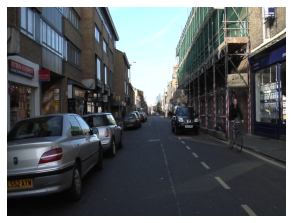

In [ ]:
img = PILImage.create(images[0])
img.show(figsize=(5,5))

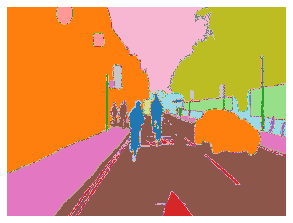

In [ ]:
lbl = PILMask.create(labels[0])
lbl.show(figsize=(5,5), alpha=1)

One problem is that the list of images and labels are not in order, so they don't correspond to one another. We need a function that gives us the path to the mask that matches the right image.

In [ ]:
def get_mask(filename):
    return path/'labels'/f'{filename.stem}_P{filename.suffix}'

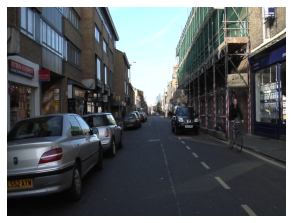

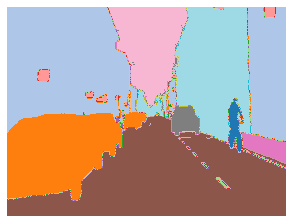

In [ ]:
img = PILImage.create(images[0])
mask = PILMask.create(get_mask(images[0]))
img.show(figsize=(5,5))
mask.show(figsize=(5,5), alpha=1)

Perfect! Now let's examine the mask a little closer

In [ ]:
tensor(mask)

tensor([[ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        [ 4,  4,  4,  ...,  4,  4,  4],
        ...,
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17]], dtype=torch.uint8)

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Progressive Resizing

In [ ]:
full_size = mask.shape
full_size

(720, 960)

In [ ]:
half_size = (360, 480)

We now have everything we need to assemble our `DataLoaders`.

Remeber, fastai classes and functions are super generic and flexible, so we can use both the techniques we used previously (transfer learning and data augmentation) together in the same waywe did before!

In [ ]:
data = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
                 get_items = get_image_files,
                 splitter = FileSplitter(path/'valid.txt'),
                 get_y = get_mask,
                 batch_tfms = [*aug_transforms(size=half_size), Normalize.from_stats(*imagenet_stats)]
                )

In [ ]:
dls = data.dataloaders(path/'images', bs=8)

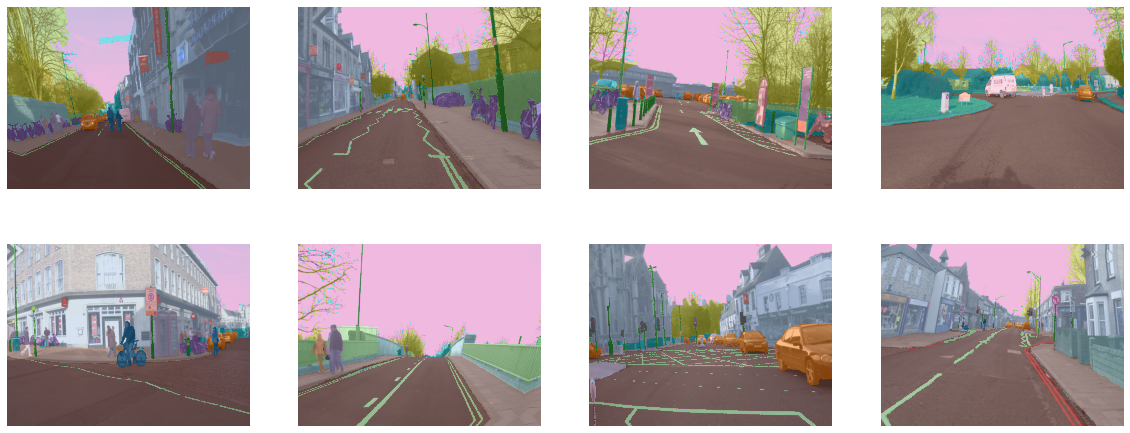

In [ ]:
dls.show_batch(figsize=(20, 8))

There are a few more things we need to take care of to ensure that we get resonable and interpretable outputs.

In [ ]:
dls.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

Specifically, we want to make sure that we don't count the "unknown" or "void" class when we compute accuracy (this is how the CAMVID accuracy is defined, and you'll see that it makes a difference).

In [ ]:
def camvid_accuracy(pred, real):
    real = real.squeeze(1)
    mask = real != void_code
    return (pred.argmax(dim=1)[mask] == targ[mask]).float().mean()

## UNet Learner & The Small Things That Make A Difference

In [ ]:
config = unet_config(self_attention=True, act_cls=Mish)
learn = unet_learner(dls, resnet18, metrics=[camvid_accuracy], config=config, opt_func=ranger)

There's another handy function that tells up what's going on with our model. It can be useful when you're analyzing a particular architecture or 

In [ ]:
learn.summary()

DynamicUnet (Input shape: ['8 x 3 x 360 x 480'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 180 x 240   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 180 x 240   128        True      
________________________________________________________________
ReLU                 8 x 64 x 180 x 240   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 90 x 120    0          False     
________________________________________________________________
Conv2d               8 x 64 x 90 x 120    36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 90 x 120    128        True      
________________________________________________________________
ReLU                 8 x 64 x 90 x 120    0          False     
_________________________________________________

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.001737800776027143)

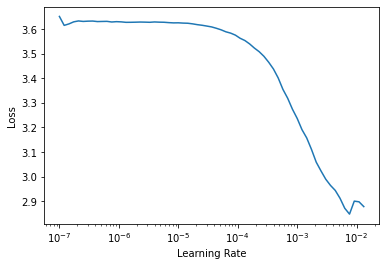

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3

In [ ]:
learn.fine_tune(15, slice(lr), freeze_epochs = 10)

TypeError: unsupported operand type(s) for /: 'slice' and 'int'

In [ ]:
learn.save('xresnet50_half.pkl')

In [ ]:
learn.show_results(figsize=(20,8))